# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

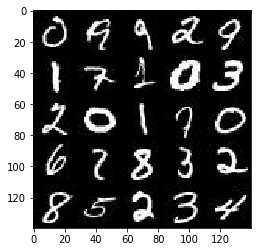

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

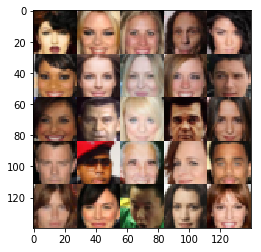

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_image  = tf.placeholder(tf.float32, (None, image_width, image_height,  image_channels), name = 'inputs_image')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    return inputs_image, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #input image 28*28*3
        x1 =  tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1,x1)
        
        ##image 14*14*64
        x2 =  tf.layers.conv2d(relu1, 128,5 ,strides=2, padding='same')
        bn2 =  tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2,bn2)
        
        ##image 7*7*128
        x3 =  tf.layers.conv2d(relu2, 256, 5,strides=2, padding='same')
        bn3 =  tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3,bn3)
        #
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        # shape = 7x7x512
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='same', activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        # shape = 14x14x256
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same', activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        # shape = 28x28x128
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 3, strides=1, padding='same', activation=None)
        # shape = 28x28x5
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.5384... Generator Loss: 26.6908
Epoch 1/2... Batch 20... Discriminator Loss: 0.4888... Generator Loss: 8.2362
Epoch 1/2... Batch 30... Discriminator Loss: 0.6036... Generator Loss: 4.2163
Epoch 1/2... Batch 40... Discriminator Loss: 0.4445... Generator Loss: 5.3560
Epoch 1/2... Batch 50... Discriminator Loss: 0.8771... Generator Loss: 1.4560
Epoch 1/2... Batch 60... Discriminator Loss: 0.5664... Generator Loss: 1.8484
Epoch 1/2... Batch 70... Discriminator Loss: 1.0535... Generator Loss: 1.6436
Epoch 1/2... Batch 80... Discriminator Loss: 1.3558... Generator Loss: 3.5435
Epoch 1/2... Batch 90... Discriminator Loss: 1.3837... Generator Loss: 0.7798
Epoch 1/2... Batch 100... Discriminator Loss: 0.8595... Generator Loss: 1.8065


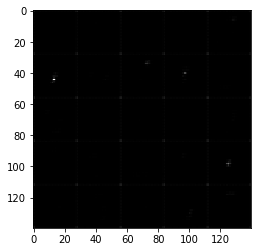

Epoch 1/2... Batch 110... Discriminator Loss: 1.3540... Generator Loss: 0.6239
Epoch 1/2... Batch 120... Discriminator Loss: 0.9320... Generator Loss: 1.5119
Epoch 1/2... Batch 130... Discriminator Loss: 0.9129... Generator Loss: 1.3315
Epoch 1/2... Batch 140... Discriminator Loss: 1.0057... Generator Loss: 1.0930
Epoch 1/2... Batch 150... Discriminator Loss: 1.3335... Generator Loss: 0.5981
Epoch 1/2... Batch 160... Discriminator Loss: 1.3813... Generator Loss: 0.8329
Epoch 1/2... Batch 170... Discriminator Loss: 1.7984... Generator Loss: 0.3391
Epoch 1/2... Batch 180... Discriminator Loss: 1.0250... Generator Loss: 1.8930
Epoch 1/2... Batch 190... Discriminator Loss: 1.2413... Generator Loss: 0.7255
Epoch 1/2... Batch 200... Discriminator Loss: 1.0057... Generator Loss: 1.4200


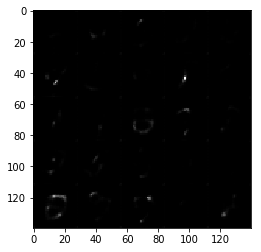

Epoch 1/2... Batch 210... Discriminator Loss: 1.2359... Generator Loss: 2.6388
Epoch 1/2... Batch 220... Discriminator Loss: 1.1926... Generator Loss: 1.2535
Epoch 1/2... Batch 230... Discriminator Loss: 1.1109... Generator Loss: 1.6105
Epoch 1/2... Batch 240... Discriminator Loss: 1.1616... Generator Loss: 0.8177
Epoch 1/2... Batch 250... Discriminator Loss: 1.3888... Generator Loss: 1.8153
Epoch 1/2... Batch 260... Discriminator Loss: 1.1435... Generator Loss: 1.0420
Epoch 1/2... Batch 270... Discriminator Loss: 1.3143... Generator Loss: 0.6434
Epoch 1/2... Batch 280... Discriminator Loss: 1.2642... Generator Loss: 0.9412
Epoch 1/2... Batch 290... Discriminator Loss: 1.7264... Generator Loss: 2.3567
Epoch 1/2... Batch 300... Discriminator Loss: 1.1877... Generator Loss: 1.1511


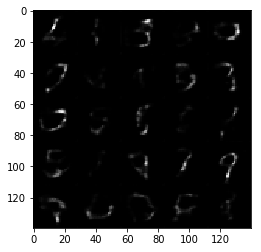

Epoch 1/2... Batch 310... Discriminator Loss: 1.1348... Generator Loss: 0.9920
Epoch 1/2... Batch 320... Discriminator Loss: 1.1618... Generator Loss: 0.8020
Epoch 1/2... Batch 330... Discriminator Loss: 1.1417... Generator Loss: 0.9122
Epoch 1/2... Batch 340... Discriminator Loss: 1.2856... Generator Loss: 1.3935
Epoch 1/2... Batch 350... Discriminator Loss: 1.2227... Generator Loss: 0.7359
Epoch 1/2... Batch 360... Discriminator Loss: 1.1895... Generator Loss: 0.9212
Epoch 1/2... Batch 370... Discriminator Loss: 1.0108... Generator Loss: 1.6374
Epoch 1/2... Batch 380... Discriminator Loss: 1.2326... Generator Loss: 0.7780
Epoch 1/2... Batch 390... Discriminator Loss: 1.0360... Generator Loss: 0.9868
Epoch 1/2... Batch 400... Discriminator Loss: 1.0618... Generator Loss: 0.9851


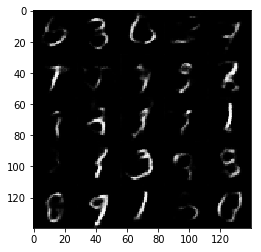

Epoch 1/2... Batch 410... Discriminator Loss: 1.1971... Generator Loss: 1.6174
Epoch 1/2... Batch 420... Discriminator Loss: 1.1497... Generator Loss: 1.3225
Epoch 1/2... Batch 430... Discriminator Loss: 1.2086... Generator Loss: 0.7376
Epoch 1/2... Batch 440... Discriminator Loss: 1.2002... Generator Loss: 1.5053
Epoch 1/2... Batch 450... Discriminator Loss: 1.1818... Generator Loss: 0.8331
Epoch 1/2... Batch 460... Discriminator Loss: 1.0893... Generator Loss: 1.0807
Epoch 2/2... Batch 10... Discriminator Loss: 1.2143... Generator Loss: 1.1080
Epoch 2/2... Batch 20... Discriminator Loss: 1.3175... Generator Loss: 0.6028
Epoch 2/2... Batch 30... Discriminator Loss: 1.1384... Generator Loss: 1.0776
Epoch 2/2... Batch 40... Discriminator Loss: 1.1423... Generator Loss: 0.9409
Epoch 2/2... Batch 50... Discriminator Loss: 1.1121... Generator Loss: 1.0871
Epoch 2/2... Batch 60... Discriminator Loss: 1.3901... Generator Loss: 1.4149
Epoch 2/2... Batch 70... Discriminator Loss: 1.2423... Gen

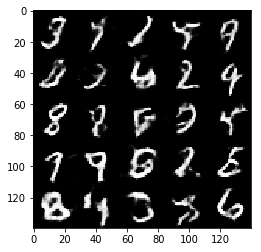

Epoch 2/2... Batch 110... Discriminator Loss: 1.3220... Generator Loss: 1.2177
Epoch 2/2... Batch 120... Discriminator Loss: 1.2145... Generator Loss: 1.1214
Epoch 2/2... Batch 130... Discriminator Loss: 1.2404... Generator Loss: 1.2749
Epoch 2/2... Batch 140... Discriminator Loss: 1.2019... Generator Loss: 1.0364
Epoch 2/2... Batch 150... Discriminator Loss: 1.2286... Generator Loss: 0.6764
Epoch 2/2... Batch 160... Discriminator Loss: 1.2384... Generator Loss: 1.1266
Epoch 2/2... Batch 170... Discriminator Loss: 1.3473... Generator Loss: 0.5656
Epoch 2/2... Batch 180... Discriminator Loss: 1.3030... Generator Loss: 0.6079
Epoch 2/2... Batch 190... Discriminator Loss: 1.1849... Generator Loss: 1.0882
Epoch 2/2... Batch 200... Discriminator Loss: 1.2471... Generator Loss: 0.8150


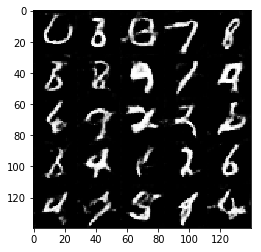

Epoch 2/2... Batch 210... Discriminator Loss: 1.3527... Generator Loss: 0.5770
Epoch 2/2... Batch 220... Discriminator Loss: 1.2231... Generator Loss: 0.7625
Epoch 2/2... Batch 230... Discriminator Loss: 1.3701... Generator Loss: 1.5182
Epoch 2/2... Batch 240... Discriminator Loss: 1.1817... Generator Loss: 0.9819
Epoch 2/2... Batch 250... Discriminator Loss: 1.9824... Generator Loss: 0.2764
Epoch 2/2... Batch 260... Discriminator Loss: 1.3612... Generator Loss: 0.8557
Epoch 2/2... Batch 270... Discriminator Loss: 1.2341... Generator Loss: 0.7864
Epoch 2/2... Batch 280... Discriminator Loss: 1.2814... Generator Loss: 1.1349
Epoch 2/2... Batch 290... Discriminator Loss: 1.2964... Generator Loss: 0.6599
Epoch 2/2... Batch 300... Discriminator Loss: 1.2264... Generator Loss: 1.2945


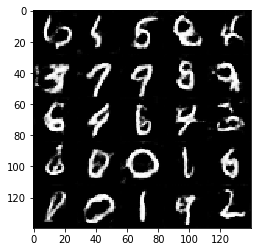

Epoch 2/2... Batch 310... Discriminator Loss: 1.2364... Generator Loss: 0.8552
Epoch 2/2... Batch 320... Discriminator Loss: 1.1890... Generator Loss: 0.9824
Epoch 2/2... Batch 330... Discriminator Loss: 1.1753... Generator Loss: 1.0120
Epoch 2/2... Batch 340... Discriminator Loss: 1.2901... Generator Loss: 0.8226
Epoch 2/2... Batch 350... Discriminator Loss: 1.3221... Generator Loss: 1.2923
Epoch 2/2... Batch 360... Discriminator Loss: 1.5789... Generator Loss: 0.4238
Epoch 2/2... Batch 370... Discriminator Loss: 1.2771... Generator Loss: 0.7825
Epoch 2/2... Batch 380... Discriminator Loss: 1.4453... Generator Loss: 1.6699
Epoch 2/2... Batch 390... Discriminator Loss: 1.3789... Generator Loss: 0.5847
Epoch 2/2... Batch 400... Discriminator Loss: 1.2746... Generator Loss: 0.6635


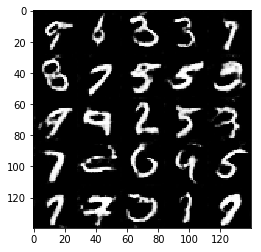

Epoch 2/2... Batch 410... Discriminator Loss: 1.3891... Generator Loss: 0.6204
Epoch 2/2... Batch 420... Discriminator Loss: 1.4055... Generator Loss: 0.5379
Epoch 2/2... Batch 430... Discriminator Loss: 1.1257... Generator Loss: 1.3208
Epoch 2/2... Batch 440... Discriminator Loss: 1.5517... Generator Loss: 2.0447
Epoch 2/2... Batch 450... Discriminator Loss: 1.1822... Generator Loss: 0.9102
Epoch 2/2... Batch 460... Discriminator Loss: 1.6315... Generator Loss: 0.4398


In [ ]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.0868... Generator Loss: 0.8485
Epoch 1/1... Batch 20... Discriminator Loss: 0.6462... Generator Loss: 1.6799
Epoch 1/1... Batch 30... Discriminator Loss: 0.5564... Generator Loss: 1.9541
Epoch 1/1... Batch 40... Discriminator Loss: 0.4671... Generator Loss: 2.4314
Epoch 1/1... Batch 50... Discriminator Loss: 0.4147... Generator Loss: 2.8895
Epoch 1/1... Batch 60... Discriminator Loss: 0.4006... Generator Loss: 3.2747
Epoch 1/1... Batch 70... Discriminator Loss: 0.3728... Generator Loss: 3.6504
Epoch 1/1... Batch 80... Discriminator Loss: 0.5380... Generator Loss: 2.2190
Epoch 1/1... Batch 90... Discriminator Loss: 0.4134... Generator Loss: 3.0713
Epoch 1/1... Batch 100... Discriminator Loss: 0.4658... Generator Loss: 2.6199


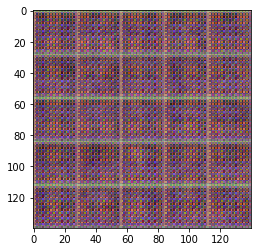

Epoch 1/1... Batch 110... Discriminator Loss: 0.8417... Generator Loss: 1.2330
Epoch 1/1... Batch 120... Discriminator Loss: 1.1513... Generator Loss: 0.9506
Epoch 1/1... Batch 130... Discriminator Loss: 0.7014... Generator Loss: 1.6463
Epoch 1/1... Batch 140... Discriminator Loss: 0.7805... Generator Loss: 3.5204
Epoch 1/1... Batch 150... Discriminator Loss: 0.7039... Generator Loss: 1.5134
Epoch 1/1... Batch 160... Discriminator Loss: 0.5112... Generator Loss: 2.3381
Epoch 1/1... Batch 170... Discriminator Loss: 0.4499... Generator Loss: 2.8476
Epoch 1/1... Batch 180... Discriminator Loss: 0.4609... Generator Loss: 2.7932
Epoch 1/1... Batch 190... Discriminator Loss: 0.5236... Generator Loss: 1.9847
Epoch 1/1... Batch 200... Discriminator Loss: 0.3840... Generator Loss: 3.6391


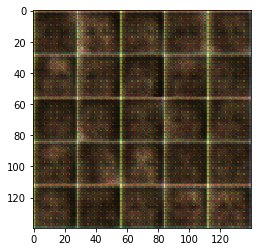

Epoch 1/1... Batch 210... Discriminator Loss: 0.4049... Generator Loss: 3.1634
Epoch 1/1... Batch 220... Discriminator Loss: 0.3805... Generator Loss: 3.8224
Epoch 1/1... Batch 230... Discriminator Loss: 0.3832... Generator Loss: 3.5643
Epoch 1/1... Batch 240... Discriminator Loss: 0.9330... Generator Loss: 1.0013
Epoch 1/1... Batch 250... Discriminator Loss: 0.9290... Generator Loss: 1.1820
Epoch 1/1... Batch 260... Discriminator Loss: 1.4004... Generator Loss: 0.6117
Epoch 1/1... Batch 270... Discriminator Loss: 1.4057... Generator Loss: 0.5697
Epoch 1/1... Batch 280... Discriminator Loss: 0.9178... Generator Loss: 1.1071
Epoch 1/1... Batch 290... Discriminator Loss: 1.2937... Generator Loss: 4.5136
Epoch 1/1... Batch 300... Discriminator Loss: 1.2684... Generator Loss: 0.6492


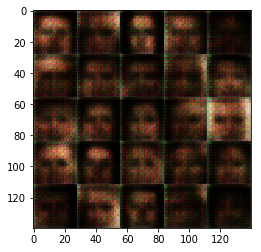

Epoch 1/1... Batch 310... Discriminator Loss: 0.5978... Generator Loss: 2.4755
Epoch 1/1... Batch 320... Discriminator Loss: 0.6223... Generator Loss: 2.1420
Epoch 1/1... Batch 330... Discriminator Loss: 0.5292... Generator Loss: 2.2634
Epoch 1/1... Batch 340... Discriminator Loss: 0.7256... Generator Loss: 1.6335
Epoch 1/1... Batch 350... Discriminator Loss: 0.5780... Generator Loss: 2.4395
Epoch 1/1... Batch 360... Discriminator Loss: 0.5176... Generator Loss: 2.9619
Epoch 1/1... Batch 370... Discriminator Loss: 0.7918... Generator Loss: 1.4151
Epoch 1/1... Batch 380... Discriminator Loss: 0.5730... Generator Loss: 2.3452
Epoch 1/1... Batch 390... Discriminator Loss: 0.6708... Generator Loss: 2.1213
Epoch 1/1... Batch 400... Discriminator Loss: 0.7651... Generator Loss: 1.4311


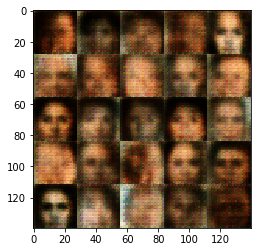

Epoch 1/1... Batch 410... Discriminator Loss: 1.6802... Generator Loss: 0.3927
Epoch 1/1... Batch 420... Discriminator Loss: 0.7896... Generator Loss: 1.2548
Epoch 1/1... Batch 430... Discriminator Loss: 0.7102... Generator Loss: 1.5863
Epoch 1/1... Batch 440... Discriminator Loss: 0.7158... Generator Loss: 1.6602
Epoch 1/1... Batch 450... Discriminator Loss: 1.3177... Generator Loss: 0.5756
Epoch 1/1... Batch 460... Discriminator Loss: 0.6886... Generator Loss: 2.3905
Epoch 1/1... Batch 470... Discriminator Loss: 0.8485... Generator Loss: 3.0677
Epoch 1/1... Batch 480... Discriminator Loss: 0.7522... Generator Loss: 1.5856
Epoch 1/1... Batch 490... Discriminator Loss: 0.7304... Generator Loss: 2.6347
Epoch 1/1... Batch 500... Discriminator Loss: 0.6789... Generator Loss: 1.5936


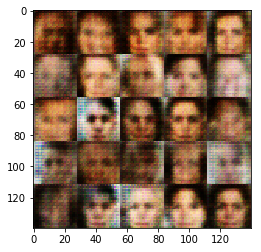

Epoch 1/1... Batch 510... Discriminator Loss: 0.7686... Generator Loss: 1.4832
Epoch 1/1... Batch 520... Discriminator Loss: 0.8480... Generator Loss: 1.1741
Epoch 1/1... Batch 530... Discriminator Loss: 1.2455... Generator Loss: 0.6499
Epoch 1/1... Batch 540... Discriminator Loss: 1.5533... Generator Loss: 0.4394
Epoch 1/1... Batch 550... Discriminator Loss: 1.2182... Generator Loss: 1.1204
Epoch 1/1... Batch 560... Discriminator Loss: 0.9139... Generator Loss: 1.2553
Epoch 1/1... Batch 570... Discriminator Loss: 1.3334... Generator Loss: 0.5660
Epoch 1/1... Batch 580... Discriminator Loss: 1.3350... Generator Loss: 0.6368
Epoch 1/1... Batch 590... Discriminator Loss: 0.8448... Generator Loss: 1.9780
Epoch 1/1... Batch 600... Discriminator Loss: 2.1969... Generator Loss: 0.2170


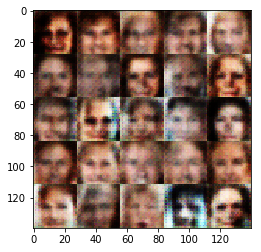

Epoch 1/1... Batch 610... Discriminator Loss: 0.7140... Generator Loss: 1.9487
Epoch 1/1... Batch 620... Discriminator Loss: 1.2233... Generator Loss: 0.9510
Epoch 1/1... Batch 630... Discriminator Loss: 1.5457... Generator Loss: 1.2714
Epoch 1/1... Batch 640... Discriminator Loss: 0.9149... Generator Loss: 2.1141
Epoch 1/1... Batch 650... Discriminator Loss: 1.1108... Generator Loss: 1.0763
Epoch 1/1... Batch 660... Discriminator Loss: 1.1811... Generator Loss: 0.8359
Epoch 1/1... Batch 670... Discriminator Loss: 1.2324... Generator Loss: 1.4971
Epoch 1/1... Batch 680... Discriminator Loss: 1.4596... Generator Loss: 1.8260
Epoch 1/1... Batch 690... Discriminator Loss: 1.0592... Generator Loss: 1.1038
Epoch 1/1... Batch 700... Discriminator Loss: 1.1024... Generator Loss: 1.2242


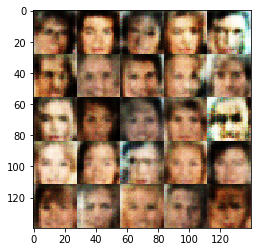

Epoch 1/1... Batch 710... Discriminator Loss: 1.4169... Generator Loss: 0.8383
Epoch 1/1... Batch 720... Discriminator Loss: 1.3556... Generator Loss: 0.8075
Epoch 1/1... Batch 730... Discriminator Loss: 1.3803... Generator Loss: 0.8621
Epoch 1/1... Batch 740... Discriminator Loss: 1.3269... Generator Loss: 0.6868
Epoch 1/1... Batch 750... Discriminator Loss: 1.3109... Generator Loss: 1.0271
Epoch 1/1... Batch 760... Discriminator Loss: 1.1004... Generator Loss: 1.3457
Epoch 1/1... Batch 770... Discriminator Loss: 1.1378... Generator Loss: 1.0330
Epoch 1/1... Batch 780... Discriminator Loss: 1.2927... Generator Loss: 0.7836
Epoch 1/1... Batch 790... Discriminator Loss: 1.0759... Generator Loss: 1.0683
Epoch 1/1... Batch 800... Discriminator Loss: 1.2981... Generator Loss: 0.9911


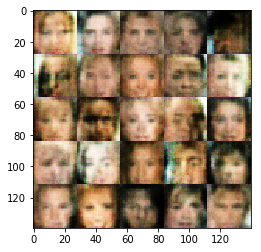

Epoch 1/1... Batch 810... Discriminator Loss: 1.3082... Generator Loss: 0.8166
Epoch 1/1... Batch 820... Discriminator Loss: 1.1767... Generator Loss: 1.2109
Epoch 1/1... Batch 830... Discriminator Loss: 1.3628... Generator Loss: 0.9433
Epoch 1/1... Batch 840... Discriminator Loss: 1.3307... Generator Loss: 0.7410
Epoch 1/1... Batch 850... Discriminator Loss: 1.2914... Generator Loss: 0.8993
Epoch 1/1... Batch 860... Discriminator Loss: 1.2013... Generator Loss: 1.0109
Epoch 1/1... Batch 870... Discriminator Loss: 1.3097... Generator Loss: 0.7577
Epoch 1/1... Batch 880... Discriminator Loss: 1.2371... Generator Loss: 0.8879
Epoch 1/1... Batch 890... Discriminator Loss: 1.2843... Generator Loss: 0.7551
Epoch 1/1... Batch 900... Discriminator Loss: 1.2709... Generator Loss: 0.8475


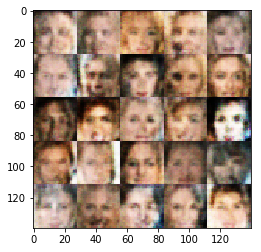

Epoch 1/1... Batch 910... Discriminator Loss: 1.0758... Generator Loss: 1.1355
Epoch 1/1... Batch 920... Discriminator Loss: 1.3090... Generator Loss: 0.9098
Epoch 1/1... Batch 930... Discriminator Loss: 1.2851... Generator Loss: 0.8945
Epoch 1/1... Batch 940... Discriminator Loss: 1.1827... Generator Loss: 0.9156
Epoch 1/1... Batch 950... Discriminator Loss: 1.2315... Generator Loss: 0.8691
Epoch 1/1... Batch 960... Discriminator Loss: 1.1709... Generator Loss: 0.9803
Epoch 1/1... Batch 970... Discriminator Loss: 1.2357... Generator Loss: 0.8193
Epoch 1/1... Batch 980... Discriminator Loss: 1.2154... Generator Loss: 0.9289
Epoch 1/1... Batch 990... Discriminator Loss: 1.2891... Generator Loss: 0.8264
Epoch 1/1... Batch 1000... Discriminator Loss: 1.1200... Generator Loss: 1.0924


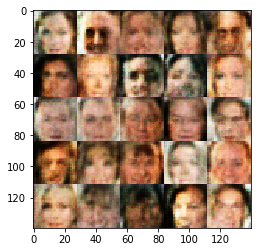

Epoch 1/1... Batch 1010... Discriminator Loss: 1.2155... Generator Loss: 1.0033
Epoch 1/1... Batch 1020... Discriminator Loss: 1.2008... Generator Loss: 0.8726
Epoch 1/1... Batch 1030... Discriminator Loss: 1.2293... Generator Loss: 0.7834
Epoch 1/1... Batch 1040... Discriminator Loss: 1.1817... Generator Loss: 1.2065
Epoch 1/1... Batch 1050... Discriminator Loss: 1.2091... Generator Loss: 0.7472
Epoch 1/1... Batch 1060... Discriminator Loss: 1.1258... Generator Loss: 0.9610
Epoch 1/1... Batch 1070... Discriminator Loss: 1.3047... Generator Loss: 0.7885
Epoch 1/1... Batch 1080... Discriminator Loss: 1.3019... Generator Loss: 0.7863
Epoch 1/1... Batch 1090... Discriminator Loss: 1.2157... Generator Loss: 1.3522
Epoch 1/1... Batch 1100... Discriminator Loss: 1.1852... Generator Loss: 0.8960


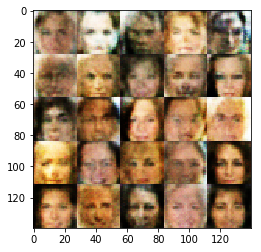

Epoch 1/1... Batch 1110... Discriminator Loss: 1.2774... Generator Loss: 0.8145
Epoch 1/1... Batch 1120... Discriminator Loss: 1.0702... Generator Loss: 1.1715
Epoch 1/1... Batch 1130... Discriminator Loss: 1.2212... Generator Loss: 1.0019
Epoch 1/1... Batch 1140... Discriminator Loss: 1.2129... Generator Loss: 0.9772
Epoch 1/1... Batch 1150... Discriminator Loss: 1.3127... Generator Loss: 0.8420
Epoch 1/1... Batch 1160... Discriminator Loss: 1.1590... Generator Loss: 0.9283
Epoch 1/1... Batch 1170... Discriminator Loss: 1.3332... Generator Loss: 0.8359
Epoch 1/1... Batch 1180... Discriminator Loss: 1.2574... Generator Loss: 0.9170
Epoch 1/1... Batch 1190... Discriminator Loss: 1.3096... Generator Loss: 0.9108
Epoch 1/1... Batch 1200... Discriminator Loss: 1.1458... Generator Loss: 0.9677


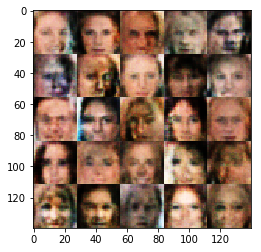

Epoch 1/1... Batch 1210... Discriminator Loss: 1.4421... Generator Loss: 0.6486
Epoch 1/1... Batch 1220... Discriminator Loss: 1.2227... Generator Loss: 0.8786
Epoch 1/1... Batch 1230... Discriminator Loss: 1.2238... Generator Loss: 0.6992
Epoch 1/1... Batch 1240... Discriminator Loss: 1.2582... Generator Loss: 0.9920
Epoch 1/1... Batch 1250... Discriminator Loss: 1.2549... Generator Loss: 1.0147
Epoch 1/1... Batch 1260... Discriminator Loss: 1.2485... Generator Loss: 0.9868
Epoch 1/1... Batch 1270... Discriminator Loss: 1.1614... Generator Loss: 0.8887
Epoch 1/1... Batch 1280... Discriminator Loss: 1.2113... Generator Loss: 0.7166
Epoch 1/1... Batch 1290... Discriminator Loss: 1.1673... Generator Loss: 0.8220
Epoch 1/1... Batch 1300... Discriminator Loss: 1.2533... Generator Loss: 0.7315


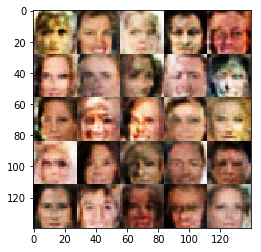

Epoch 1/1... Batch 1310... Discriminator Loss: 1.2044... Generator Loss: 0.8460
Epoch 1/1... Batch 1320... Discriminator Loss: 1.2388... Generator Loss: 0.8323
Epoch 1/1... Batch 1330... Discriminator Loss: 1.2937... Generator Loss: 0.9555
Epoch 1/1... Batch 1340... Discriminator Loss: 1.2634... Generator Loss: 0.8200
Epoch 1/1... Batch 1350... Discriminator Loss: 1.0608... Generator Loss: 1.0722
Epoch 1/1... Batch 1360... Discriminator Loss: 1.0013... Generator Loss: 1.0757
Epoch 1/1... Batch 1370... Discriminator Loss: 1.1192... Generator Loss: 1.2014
Epoch 1/1... Batch 1380... Discriminator Loss: 1.3219... Generator Loss: 0.7334
Epoch 1/1... Batch 1390... Discriminator Loss: 1.2466... Generator Loss: 0.6795
Epoch 1/1... Batch 1400... Discriminator Loss: 1.1897... Generator Loss: 0.9109


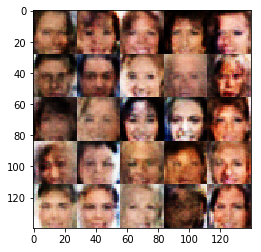

Epoch 1/1... Batch 1410... Discriminator Loss: 1.1374... Generator Loss: 0.8703
Epoch 1/1... Batch 1420... Discriminator Loss: 1.1246... Generator Loss: 1.2991
Epoch 1/1... Batch 1430... Discriminator Loss: 1.0907... Generator Loss: 0.9105
Epoch 1/1... Batch 1440... Discriminator Loss: 1.0709... Generator Loss: 0.9309
Epoch 1/1... Batch 1450... Discriminator Loss: 1.2150... Generator Loss: 0.6039
Epoch 1/1... Batch 1460... Discriminator Loss: 1.2745... Generator Loss: 0.8267
Epoch 1/1... Batch 1470... Discriminator Loss: 1.2616... Generator Loss: 0.7271
Epoch 1/1... Batch 1480... Discriminator Loss: 0.9635... Generator Loss: 1.0753
Epoch 1/1... Batch 1490... Discriminator Loss: 1.1136... Generator Loss: 1.5674
Epoch 1/1... Batch 1500... Discriminator Loss: 1.2263... Generator Loss: 2.1241


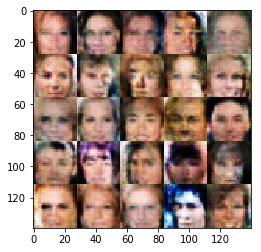

Epoch 1/1... Batch 1510... Discriminator Loss: 1.2220... Generator Loss: 0.9778
Epoch 1/1... Batch 1520... Discriminator Loss: 0.8402... Generator Loss: 1.3175
Epoch 1/1... Batch 1530... Discriminator Loss: 0.8595... Generator Loss: 1.3949
Epoch 1/1... Batch 1540... Discriminator Loss: 1.1093... Generator Loss: 0.7419
Epoch 1/1... Batch 1550... Discriminator Loss: 0.7072... Generator Loss: 2.7424
Epoch 1/1... Batch 1560... Discriminator Loss: 0.9192... Generator Loss: 1.0160
Epoch 1/1... Batch 1570... Discriminator Loss: 0.7837... Generator Loss: 3.0970
Epoch 1/1... Batch 1580... Discriminator Loss: 1.6130... Generator Loss: 0.3791
Epoch 1/1... Batch 1590... Discriminator Loss: 1.0262... Generator Loss: 1.7686
Epoch 1/1... Batch 1600... Discriminator Loss: 0.7795... Generator Loss: 1.7107


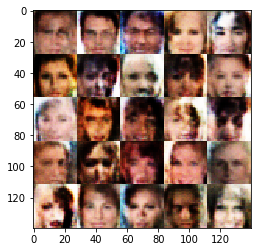

Epoch 1/1... Batch 1610... Discriminator Loss: 0.7558... Generator Loss: 1.5860
Epoch 1/1... Batch 1620... Discriminator Loss: 0.8808... Generator Loss: 0.9931
Epoch 1/1... Batch 1630... Discriminator Loss: 1.5379... Generator Loss: 0.4047
Epoch 1/1... Batch 1640... Discriminator Loss: 0.8714... Generator Loss: 2.0826
Epoch 1/1... Batch 1650... Discriminator Loss: 1.2767... Generator Loss: 0.5724
Epoch 1/1... Batch 1660... Discriminator Loss: 0.9004... Generator Loss: 3.0611
Epoch 1/1... Batch 1670... Discriminator Loss: 0.5333... Generator Loss: 3.7111
Epoch 1/1... Batch 1680... Discriminator Loss: 1.0330... Generator Loss: 0.8540
Epoch 1/1... Batch 1690... Discriminator Loss: 0.8596... Generator Loss: 2.5783
Epoch 1/1... Batch 1700... Discriminator Loss: 0.9259... Generator Loss: 1.5724


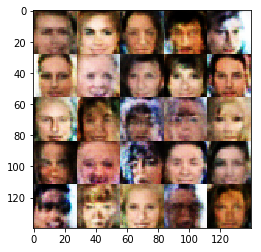

Epoch 1/1... Batch 1710... Discriminator Loss: 1.7400... Generator Loss: 0.3204
Epoch 1/1... Batch 1720... Discriminator Loss: 0.8298... Generator Loss: 1.0684
Epoch 1/1... Batch 1730... Discriminator Loss: 2.2190... Generator Loss: 0.2045
Epoch 1/1... Batch 1740... Discriminator Loss: 1.1148... Generator Loss: 0.7415
Epoch 1/1... Batch 1750... Discriminator Loss: 1.0690... Generator Loss: 0.8157
Epoch 1/1... Batch 1760... Discriminator Loss: 1.1083... Generator Loss: 2.1542
Epoch 1/1... Batch 1770... Discriminator Loss: 0.5967... Generator Loss: 2.4756
Epoch 1/1... Batch 1780... Discriminator Loss: 0.5402... Generator Loss: 2.5844
Epoch 1/1... Batch 1790... Discriminator Loss: 1.4266... Generator Loss: 0.4571
Epoch 1/1... Batch 1800... Discriminator Loss: 0.8251... Generator Loss: 1.1581


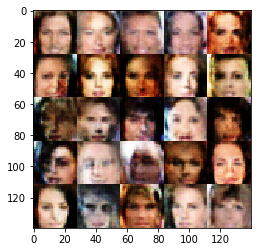

Epoch 1/1... Batch 1810... Discriminator Loss: 0.8487... Generator Loss: 2.6983
Epoch 1/1... Batch 1820... Discriminator Loss: 0.5781... Generator Loss: 2.4891
Epoch 1/1... Batch 1830... Discriminator Loss: 0.6003... Generator Loss: 1.8776
Epoch 1/1... Batch 1840... Discriminator Loss: 0.5903... Generator Loss: 1.8343
Epoch 1/1... Batch 1850... Discriminator Loss: 1.1392... Generator Loss: 0.6882
Epoch 1/1... Batch 1860... Discriminator Loss: 0.8644... Generator Loss: 1.0991
Epoch 1/1... Batch 1870... Discriminator Loss: 1.1124... Generator Loss: 0.7060
Epoch 1/1... Batch 1880... Discriminator Loss: 0.5220... Generator Loss: 2.2371
Epoch 1/1... Batch 1890... Discriminator Loss: 0.7832... Generator Loss: 3.7345
Epoch 1/1... Batch 1900... Discriminator Loss: 1.4228... Generator Loss: 0.6768


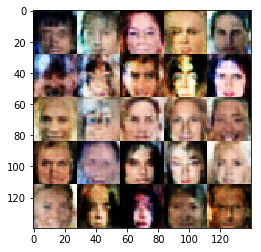

Epoch 1/1... Batch 1910... Discriminator Loss: 0.7736... Generator Loss: 2.6618
Epoch 1/1... Batch 1920... Discriminator Loss: 0.9401... Generator Loss: 5.1505
Epoch 1/1... Batch 1930... Discriminator Loss: 0.8430... Generator Loss: 1.1535
Epoch 1/1... Batch 1940... Discriminator Loss: 0.7598... Generator Loss: 1.2139
Epoch 1/1... Batch 1950... Discriminator Loss: 0.9508... Generator Loss: 0.9112
Epoch 1/1... Batch 1960... Discriminator Loss: 0.8552... Generator Loss: 1.0293
Epoch 1/1... Batch 1970... Discriminator Loss: 0.7656... Generator Loss: 1.1390
Epoch 1/1... Batch 1980... Discriminator Loss: 0.8533... Generator Loss: 2.0156
Epoch 1/1... Batch 1990... Discriminator Loss: 0.9287... Generator Loss: 1.0116
Epoch 1/1... Batch 2000... Discriminator Loss: 0.6518... Generator Loss: 1.5851


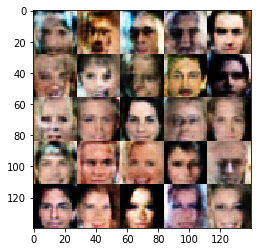

Epoch 1/1... Batch 2010... Discriminator Loss: 0.6334... Generator Loss: 2.3909
Epoch 1/1... Batch 2020... Discriminator Loss: 0.7119... Generator Loss: 3.2006
Epoch 1/1... Batch 2030... Discriminator Loss: 1.1909... Generator Loss: 2.5417
Epoch 1/1... Batch 2040... Discriminator Loss: 0.6583... Generator Loss: 1.4603
Epoch 1/1... Batch 2050... Discriminator Loss: 1.5882... Generator Loss: 0.3817
Epoch 1/1... Batch 2060... Discriminator Loss: 0.8433... Generator Loss: 1.0761
Epoch 1/1... Batch 2070... Discriminator Loss: 1.5624... Generator Loss: 0.3994
Epoch 1/1... Batch 2080... Discriminator Loss: 1.3216... Generator Loss: 3.3236
Epoch 1/1... Batch 2090... Discriminator Loss: 0.6666... Generator Loss: 1.7095
Epoch 1/1... Batch 2100... Discriminator Loss: 0.6939... Generator Loss: 2.8665


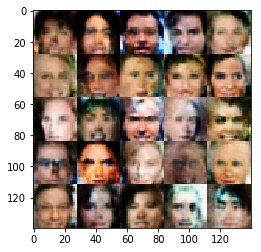

Epoch 1/1... Batch 2110... Discriminator Loss: 0.7862... Generator Loss: 1.2048
Epoch 1/1... Batch 2120... Discriminator Loss: 0.7641... Generator Loss: 1.2607
Epoch 1/1... Batch 2130... Discriminator Loss: 0.5621... Generator Loss: 3.2926
Epoch 1/1... Batch 2140... Discriminator Loss: 0.9896... Generator Loss: 3.4318
Epoch 1/1... Batch 2150... Discriminator Loss: 0.9760... Generator Loss: 0.8677
Epoch 1/1... Batch 2160... Discriminator Loss: 1.0065... Generator Loss: 0.8904
Epoch 1/1... Batch 2170... Discriminator Loss: 0.5146... Generator Loss: 2.3267
Epoch 1/1... Batch 2180... Discriminator Loss: 0.6524... Generator Loss: 1.9290
Epoch 1/1... Batch 2190... Discriminator Loss: 0.6758... Generator Loss: 1.7447
Epoch 1/1... Batch 2200... Discriminator Loss: 0.5592... Generator Loss: 2.3680


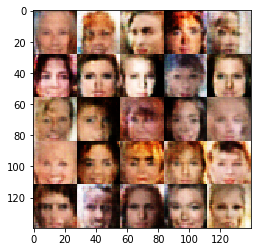

Epoch 1/1... Batch 2210... Discriminator Loss: 1.7319... Generator Loss: 0.3255
Epoch 1/1... Batch 2220... Discriminator Loss: 0.6913... Generator Loss: 1.4506
Epoch 1/1... Batch 2230... Discriminator Loss: 1.0173... Generator Loss: 3.8292
Epoch 1/1... Batch 2240... Discriminator Loss: 0.6794... Generator Loss: 4.5740
Epoch 1/1... Batch 2250... Discriminator Loss: 1.2069... Generator Loss: 0.6139
Epoch 1/1... Batch 2260... Discriminator Loss: 1.4096... Generator Loss: 0.4748
Epoch 1/1... Batch 2270... Discriminator Loss: 2.1999... Generator Loss: 2.5121
Epoch 1/1... Batch 2280... Discriminator Loss: 0.6955... Generator Loss: 1.3714
Epoch 1/1... Batch 2290... Discriminator Loss: 0.6533... Generator Loss: 3.5658
Epoch 1/1... Batch 2300... Discriminator Loss: 0.6184... Generator Loss: 1.7614


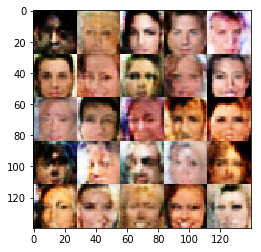

Epoch 1/1... Batch 2310... Discriminator Loss: 0.6072... Generator Loss: 3.7911
Epoch 1/1... Batch 2320... Discriminator Loss: 0.7273... Generator Loss: 3.2667
Epoch 1/1... Batch 2330... Discriminator Loss: 1.3721... Generator Loss: 0.5218
Epoch 1/1... Batch 2340... Discriminator Loss: 0.3901... Generator Loss: 3.9037
Epoch 1/1... Batch 2350... Discriminator Loss: 0.7287... Generator Loss: 2.0660
Epoch 1/1... Batch 2360... Discriminator Loss: 0.7961... Generator Loss: 1.8135
Epoch 1/1... Batch 2370... Discriminator Loss: 0.6730... Generator Loss: 2.7481
Epoch 1/1... Batch 2380... Discriminator Loss: 0.6208... Generator Loss: 1.7802
Epoch 1/1... Batch 2390... Discriminator Loss: 1.0206... Generator Loss: 0.8008
Epoch 1/1... Batch 2400... Discriminator Loss: 0.6352... Generator Loss: 1.6293


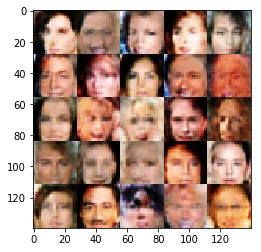

Epoch 1/1... Batch 2410... Discriminator Loss: 0.7932... Generator Loss: 1.2028
Epoch 1/1... Batch 2420... Discriminator Loss: 0.6454... Generator Loss: 1.4356
Epoch 1/1... Batch 2430... Discriminator Loss: 0.7642... Generator Loss: 1.6548
Epoch 1/1... Batch 2440... Discriminator Loss: 0.5853... Generator Loss: 2.3290
Epoch 1/1... Batch 2450... Discriminator Loss: 0.9022... Generator Loss: 1.0536
Epoch 1/1... Batch 2460... Discriminator Loss: 0.7125... Generator Loss: 1.4362
Epoch 1/1... Batch 2470... Discriminator Loss: 0.5988... Generator Loss: 2.5350
Epoch 1/1... Batch 2480... Discriminator Loss: 0.9456... Generator Loss: 1.1030
Epoch 1/1... Batch 2490... Discriminator Loss: 0.4766... Generator Loss: 2.1875
Epoch 1/1... Batch 2500... Discriminator Loss: 1.1021... Generator Loss: 0.9030


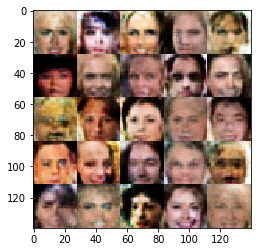

Epoch 1/1... Batch 2510... Discriminator Loss: 0.4569... Generator Loss: 3.4135
Epoch 1/1... Batch 2520... Discriminator Loss: 0.4301... Generator Loss: 3.3428
Epoch 1/1... Batch 2530... Discriminator Loss: 0.7951... Generator Loss: 2.4028
Epoch 1/1... Batch 2540... Discriminator Loss: 0.9379... Generator Loss: 0.8823
Epoch 1/1... Batch 2550... Discriminator Loss: 0.4650... Generator Loss: 2.8213
Epoch 1/1... Batch 2560... Discriminator Loss: 0.5237... Generator Loss: 2.6779
Epoch 1/1... Batch 2570... Discriminator Loss: 1.5209... Generator Loss: 0.4455
Epoch 1/1... Batch 2580... Discriminator Loss: 1.1586... Generator Loss: 0.7325
Epoch 1/1... Batch 2590... Discriminator Loss: 0.4074... Generator Loss: 4.4174
Epoch 1/1... Batch 2600... Discriminator Loss: 0.7185... Generator Loss: 2.3434


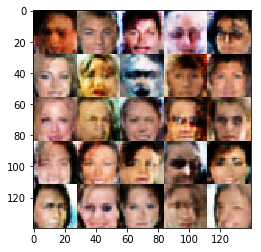

Epoch 1/1... Batch 2610... Discriminator Loss: 0.5961... Generator Loss: 1.8939
Epoch 1/1... Batch 2620... Discriminator Loss: 1.2876... Generator Loss: 0.5575
Epoch 1/1... Batch 2630... Discriminator Loss: 0.7559... Generator Loss: 1.1956
Epoch 1/1... Batch 2640... Discriminator Loss: 0.9389... Generator Loss: 1.4818
Epoch 1/1... Batch 2650... Discriminator Loss: 1.1684... Generator Loss: 0.6592
Epoch 1/1... Batch 2660... Discriminator Loss: 0.9477... Generator Loss: 1.5320
Epoch 1/1... Batch 2670... Discriminator Loss: 0.7026... Generator Loss: 1.3813
Epoch 1/1... Batch 2680... Discriminator Loss: 0.7377... Generator Loss: 1.7840
Epoch 1/1... Batch 2690... Discriminator Loss: 0.5544... Generator Loss: 2.2860
Epoch 1/1... Batch 2700... Discriminator Loss: 0.7629... Generator Loss: 3.3670


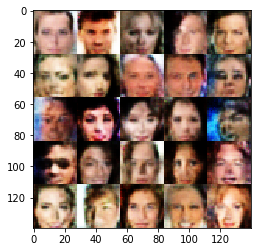

Epoch 1/1... Batch 2710... Discriminator Loss: 0.6141... Generator Loss: 2.3744
Epoch 1/1... Batch 2720... Discriminator Loss: 0.8790... Generator Loss: 1.0499
Epoch 1/1... Batch 2730... Discriminator Loss: 1.4543... Generator Loss: 3.2970
Epoch 1/1... Batch 2740... Discriminator Loss: 0.8273... Generator Loss: 1.4678
Epoch 1/1... Batch 2750... Discriminator Loss: 1.1518... Generator Loss: 0.7227
Epoch 1/1... Batch 2760... Discriminator Loss: 0.5349... Generator Loss: 2.8934
Epoch 1/1... Batch 2770... Discriminator Loss: 0.6996... Generator Loss: 1.4423
Epoch 1/1... Batch 2780... Discriminator Loss: 0.9110... Generator Loss: 1.1792
Epoch 1/1... Batch 2790... Discriminator Loss: 0.5242... Generator Loss: 2.4672
Epoch 1/1... Batch 2800... Discriminator Loss: 1.0553... Generator Loss: 1.9431


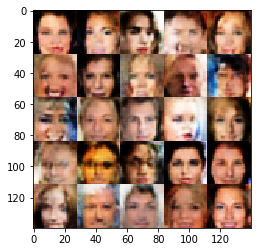

Epoch 1/1... Batch 2810... Discriminator Loss: 0.6317... Generator Loss: 2.5371
Epoch 1/1... Batch 2820... Discriminator Loss: 0.4722... Generator Loss: 2.4704
Epoch 1/1... Batch 2830... Discriminator Loss: 0.7047... Generator Loss: 2.0984
Epoch 1/1... Batch 2840... Discriminator Loss: 0.7093... Generator Loss: 1.2775
Epoch 1/1... Batch 2850... Discriminator Loss: 0.7809... Generator Loss: 1.2934
Epoch 1/1... Batch 2860... Discriminator Loss: 0.8574... Generator Loss: 1.3181
Epoch 1/1... Batch 2870... Discriminator Loss: 0.5255... Generator Loss: 2.3909
Epoch 1/1... Batch 2880... Discriminator Loss: 0.5532... Generator Loss: 2.2561
Epoch 1/1... Batch 2890... Discriminator Loss: 0.5720... Generator Loss: 3.0464
Epoch 1/1... Batch 2900... Discriminator Loss: 1.4738... Generator Loss: 0.4379


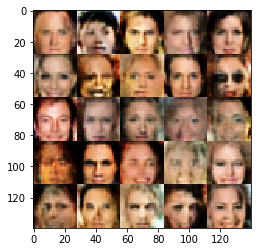

Epoch 1/1... Batch 2910... Discriminator Loss: 0.9092... Generator Loss: 1.0427
Epoch 1/1... Batch 2920... Discriminator Loss: 0.4906... Generator Loss: 2.9025
Epoch 1/1... Batch 2930... Discriminator Loss: 0.6903... Generator Loss: 2.2044
Epoch 1/1... Batch 2940... Discriminator Loss: 1.3305... Generator Loss: 2.5546
Epoch 1/1... Batch 2950... Discriminator Loss: 0.5692... Generator Loss: 1.7634
Epoch 1/1... Batch 2960... Discriminator Loss: 0.7235... Generator Loss: 2.1834
Epoch 1/1... Batch 2970... Discriminator Loss: 0.7661... Generator Loss: 1.3792
Epoch 1/1... Batch 2980... Discriminator Loss: 0.5948... Generator Loss: 1.8258
Epoch 1/1... Batch 2990... Discriminator Loss: 1.4153... Generator Loss: 1.0584
Epoch 1/1... Batch 3000... Discriminator Loss: 0.9214... Generator Loss: 0.9572


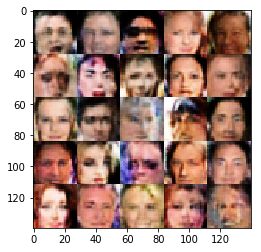

Epoch 1/1... Batch 3010... Discriminator Loss: 1.1545... Generator Loss: 0.7208
Epoch 1/1... Batch 3020... Discriminator Loss: 0.9100... Generator Loss: 0.9570
Epoch 1/1... Batch 3030... Discriminator Loss: 0.6440... Generator Loss: 4.3784
Epoch 1/1... Batch 3040... Discriminator Loss: 0.8784... Generator Loss: 1.1035
Epoch 1/1... Batch 3050... Discriminator Loss: 0.5053... Generator Loss: 2.8323
Epoch 1/1... Batch 3060... Discriminator Loss: 0.5596... Generator Loss: 2.2046
Epoch 1/1... Batch 3070... Discriminator Loss: 0.7361... Generator Loss: 2.9988
Epoch 1/1... Batch 3080... Discriminator Loss: 1.1790... Generator Loss: 0.7014
Epoch 1/1... Batch 3090... Discriminator Loss: 0.5975... Generator Loss: 1.7729
Epoch 1/1... Batch 3100... Discriminator Loss: 0.5464... Generator Loss: 2.6717


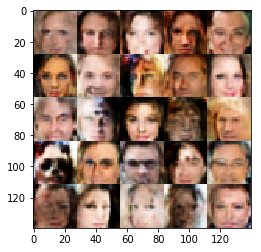

Epoch 1/1... Batch 3110... Discriminator Loss: 0.5886... Generator Loss: 1.9641
Epoch 1/1... Batch 3120... Discriminator Loss: 0.5352... Generator Loss: 2.1069
Epoch 1/1... Batch 3130... Discriminator Loss: 0.8371... Generator Loss: 1.0998


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.